In [118]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [119]:
def gaussian(x, mean, std_dev):
    return np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

def initialize_centers(data, num_centers):
    kmeans = KMeans(n_clusters=num_centers, random_state=0)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    std_devs = np.zeros(num_centers)
    for i in range(num_centers):
        std_devs[i] = np.std(data[np.where(kmeans.labels_ == i)])
    return centers, std_devs, kmeans.labels_

class RBFNetwork:
    def __init__(self, num_rbf, learning_rate):
        self.num_rbf = num_rbf
        self.learning_rate = learning_rate
        self.centers = None
        self.std_devs = None
        self.weights = None
        self.bias = None
        self.labels = None

    def fit(self, X, y):
        self.centers, self.std_devs, self.labels = initialize_centers(X, self.num_rbf)
        # Initialize weights and bias randomly
        self.weights = np.random.randn(self.num_rbf)
        self.bias = np.random.randn()

    def rbf(self, x, c, s):
        return gaussian(x, c, s)

    def predict(self, X):
        predictions = []
        for x in X:
            rbf_outputs = np.array([self.rbf(x, c, s) for c, s in zip(self.centers, self.std_devs)])
            predictions.append(np.dot(rbf_outputs.reshape(-1,), self.weights.reshape(-1,)) + self.bias)
        return np.array(predictions)

    def train(self, X, y, epochs=100):
        for epoch in range(epochs):
            for i in range(X.shape[0]):
                # Forward pass
                rbf_outputs = np.array([self.rbf(X[i], c, s) for c, s in zip(self.centers, self.std_devs)])
                predicted_output = np.dot(rbf_outputs.reshape(-1,), self.weights.reshape(-1,)) + self.bias
                loss = (predicted_output - y[i][0]) ** 2

                # Backward pass
                error = predicted_output - y[i][0]
                self.weights -= (self.learning_rate * error * rbf_outputs).reshape(-1,)
                self.bias -= self.learning_rate * error
            if epoch%50 == 0:
                print(f'Epoch {epoch}, Sample {i}, Loss: {loss:.4f}')

In [120]:
# Plot K-means clustering results
def plot_kmeans_clustering(X, centers, kmeans_labels):
    plt.scatter(X, np.zeros_like(X), c=kmeans_labels, cmap='viridis', label='Clustered Data')
    plt.scatter(centers, np.zeros_like(centers), color='red', s=100, marker='x', label='Centers')
    plt.title("K-means Clustering of RBF Centers")
    plt.xlabel("X")
    plt.legend()
    plt.show()

Epoch 0, Sample 99, Loss: 0.1458
Epoch 50, Sample 99, Loss: 0.0235
Epoch 100, Sample 99, Loss: 0.0067
Epoch 150, Sample 99, Loss: 0.0036


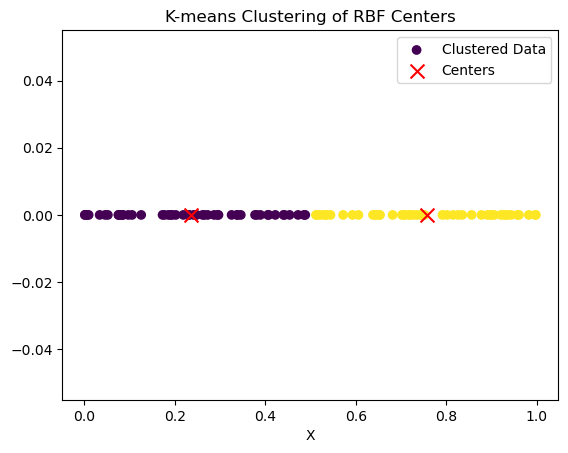

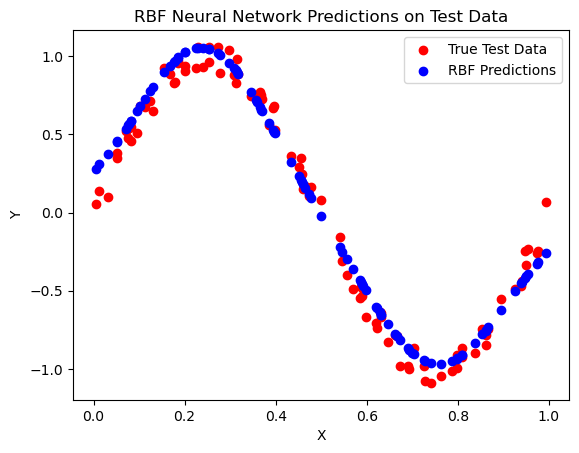

In [121]:
# Generate synthetic test data
NUM_SAMPLES = 200
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
Y = np.sin(2 * np.pi * X) + noise

# Reshape X and Y for the model
X = X.reshape(-1, 1)  # Reshape X to be a 2D array for the RBF network
Y = Y.reshape(-1, 1)  # Reshape Y for consistency

# Split the data into training and testing sets (e.g., 50% training, 20% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Initialize and train the RBF network
num_rbf = 2
learning_rate = 0.01

# Initialize and train the RBF network on training data
rbf_network = RBFNetwork(num_rbf=num_rbf, learning_rate=learning_rate)
rbf_network.fit(X_train, Y_train)
rbf_network.train(X_train, Y_train, epochs=200)

# After fitting the RBF network, plot the clustering result for training data
plot_kmeans_clustering(X_train, rbf_network.centers, rbf_network.labels)

# Test predictions on the test set
predictions = rbf_network.predict(X_test)

# Plotting the results
plt.scatter(X_test, Y_test, color='red', label='True Test Data')
plt.scatter(X_test, predictions, color='blue', label='RBF Predictions')
plt.legend()
plt.title("RBF Neural Network Predictions on Test Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


# Pytorch + BN layer

In [122]:
# Define the RBF Layer with dynamic initialization of centers and betas
class RBFLayer(nn.Module):
    def __init__(self, in_features, out_features, centers, std_devs):
        super(RBFLayer, self).__init__()
        # Use the centers and std_devs from k-means initialization
        self.centers = nn.Parameter(torch.Tensor(centers))  # RBF centers
        self.beta = nn.Parameter(torch.Tensor(1 / (2 * std_devs**2)))  # Use std_devs to initialize beta

    def forward(self, x):
        x = x.unsqueeze(1)
        centers = self.centers.unsqueeze(0)
        dist = torch.sum((x - centers) ** 2, dim=2)
        return torch.exp(-self.beta * dist)

# Define RBF Network
class RBFNetwork(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, centers, std_devs):
        super(RBFNetwork, self).__init__()
        self.rbf_layer = RBFLayer(in_features, hidden_features, centers, std_devs)
        self.fc_layer = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        rbf_output = self.rbf_layer(x)
        output = torch.sigmoid(self.fc_layer(rbf_output)) 
        return output
    
# Define RBF Network
class RBFNetwork_Reg(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, centers, std_devs):
        super(RBFNetwork_Reg, self).__init__()
        self.rbf_layer = RBFLayer(in_features, hidden_features, centers, std_devs)
        self.fc_layer = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        rbf_output = self.rbf_layer(x)
        output = self.fc_layer(rbf_output)
        return output
    
# Define RBF Network with Batch Normalization
class RBFNetwork_BN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, centers, std_devs):
        super(RBFNetwork_BN, self).__init__()
        self.rbf_layer = RBFLayer(in_features, hidden_features, centers, std_devs)
        self.batch_norm = nn.BatchNorm1d(hidden_features)  # Batch normalization after RBF layer
        self.fc_layer = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        rbf_output = self.rbf_layer(x)
        rbf_output = self.batch_norm(rbf_output)  # Apply batch normalization
        return self.fc_layer(rbf_output)

In [123]:
def train(X, Y, num_rbf=2, test=True):
    # Reshape X and Y for the model
    X = X.reshape(-1, 1)
    Y = Y.reshape(-1, 1)

    # Split the data into training and testing sets (50% training, 50% testing)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

    # Use k-means to initialize centers and standard deviations
    centers, std_devs, labels = initialize_centers(X_train, num_rbf)

    # Convert the centers and std_devs to torch tensors
    centers_tensor = torch.Tensor(centers)
    std_devs_tensor = torch.Tensor(std_devs)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    Y_train_tensor = torch.FloatTensor(Y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    Y_test_tensor = torch.FloatTensor(Y_test)

    # Set up the model
    input_dim = 1
    output_dim = 1

    # Initialize random centers for RBFs
    centers = torch.rand(num_rbf, input_dim)

    # Initialize the RBF network
    model = RBFNetwork_Reg(input_dim, num_rbf, output_dim, centers_tensor, std_devs_tensor)
    model_bn = RBFNetwork_BN(input_dim, num_rbf, output_dim, centers_tensor, std_devs_tensor)

    # Loss and optimizer
    criterion = nn.MSELoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.01)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.01)


    # Train the model
    epochs = 8000
    for epoch in range(epochs):
        model.train()
        model_bn.train()

        optimizer.zero_grad()
        optimizer_bn.zero_grad()

        outputs = model(X_train_tensor)
        outputs_bn = model_bn(X_train_tensor)

        loss = criterion(outputs, Y_train_tensor)
        loss_bn = criterion(outputs_bn, Y_train_tensor)

        loss.backward()
        loss_bn.backward()

        optimizer.step()
        optimizer_bn.step()

        if (epoch+1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}  Loss_bn: {loss_bn.item():.4f}')

    if test:
        # Test the model
        model.eval()
        model_bn.eval()
        with torch.no_grad():
            predictions = model(X_test_tensor)
            predictions_bn = model_bn(X_test_tensor)

        # Convert predictions back to numpy for plotting
        predictions = predictions.numpy()
        predictions_bn = predictions_bn.numpy()

        # Plotting the results
        plt.scatter(X_test, Y_test, color='red', label='True Test Data')
        plt.scatter(X_test, predictions, color='blue', label='RBF Predictions')
        plt.legend()
        plt.title("RBF")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

        plt.scatter(X_test, Y_test, color='red', label='True Test Data')
        plt.scatter(X_test, predictions_bn, color='blue', label='RBF Predictions')
        plt.legend()
        plt.title("RBF with BN")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()
    else:
        model.eval()
        model_bn.eval()
        return model, model_bn

Epoch [500/8000], Loss: 0.0083  Loss_bn: 0.0054
Epoch [1000/8000], Loss: 0.0057  Loss_bn: 0.0053
Epoch [1500/8000], Loss: 0.0054  Loss_bn: 0.0053
Epoch [2000/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [2500/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [3000/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [3500/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [4000/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [4500/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [5000/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [5500/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [6000/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [6500/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [7000/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [7500/8000], Loss: 0.0053  Loss_bn: 0.0053
Epoch [8000/8000], Loss: 0.0053  Loss_bn: 0.0053


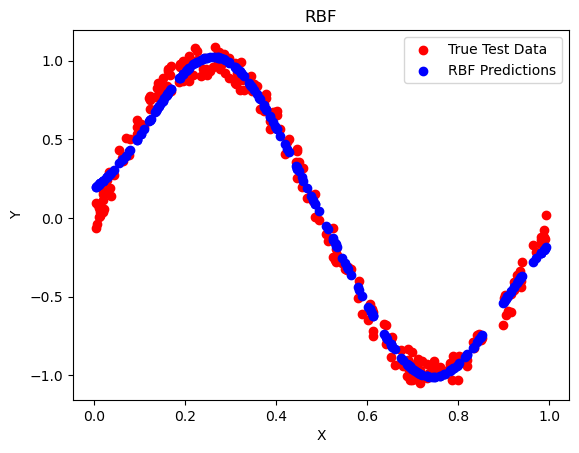

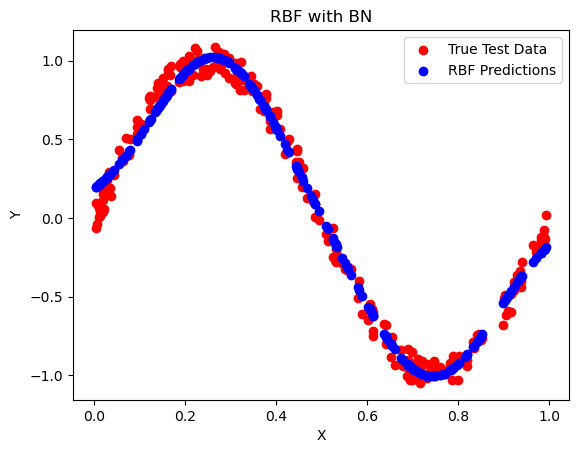

In [124]:
# Generate synthetic test data
NUM_SAMPLES = 500
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
Y = np.sin(2 * np.pi * X) + noise

train(X,Y)

# Practice

### Making datasets

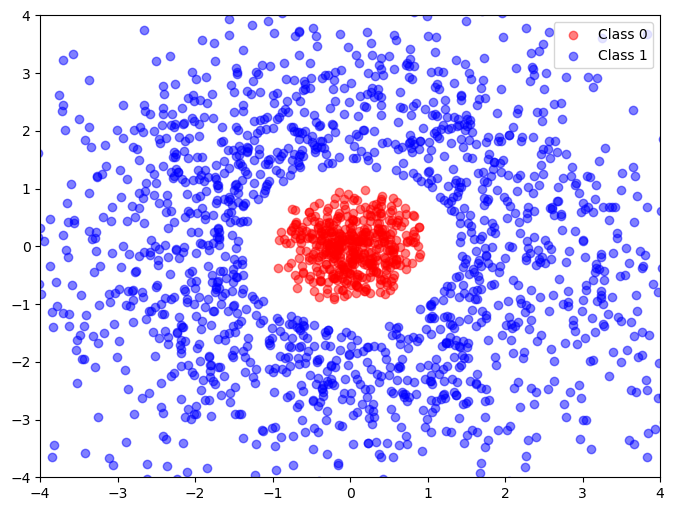

In [125]:
# Generate dataset with two centers (one for each class)
X, y = make_blobs(n_samples=[500, 2000],
                  centers=[[0, 0], [0, 0]], 
                  cluster_std=[0.5, 2], 
                  random_state=179)

q1 = X[y == 1][:, 0]
q2 =  X[y == 1][:, 1]
condition = (q1**2 + q2**2)**0.5 > 1.4
outer = X[y == 1][condition]

q1 = X[y == 0][:, 0]
q2 =  X[y == 0][:, 1]
condition = (q1**2 + q2**2)**0.5 < 1
inner = X[y == 0][condition]

data1 = np.vstack((inner, outer))
label1 = np.vstack((np.zeros((1,inner.shape[0])).reshape(-1,1) , np.ones((1,outer.shape[0])).reshape(-1,1) )).reshape(-1,)

# Plot the dataset
plt.figure(figsize=(8,6))
plt.scatter(inner[:, 0], inner[:, 1], color='red', label="Class 0", alpha=0.5)
plt.scatter(outer[:, 0], outer[:, 1], color='blue', label="Class 1", alpha=0.5)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.legend()
plt.show()

<div dir="rtl">
با توجه به شکل بالا که مربوط به داده های ما است، و با درنظر گرفتن شکل و نمودار نرمال دو بعدی، پر واضح است که کرنل نرمال انتخاب بسیار مناسبی است. چون به داده های قرمز ضریب بیسار بالا و به داده های آبی که از مرکز فاصله دارند ضریب پایین داده و دسته بندی را انجام دهد. برای دیتاست دگر نیز همین موضوع کاملا مشهود است. یعنی با درنظر گرفتن ۲ هسته، میتوان دو داده را به خوبی مشخص و دسته بندی کرد.
</div>

Epoch [1000/10000], Loss: 0.0932
Epoch [2000/10000], Loss: 0.0685
Epoch [3000/10000], Loss: 0.0426
Epoch [4000/10000], Loss: 0.0213
Epoch [5000/10000], Loss: 0.0104
Epoch [6000/10000], Loss: 0.0057
Epoch [7000/10000], Loss: 0.0036
Epoch [8000/10000], Loss: 0.0026
Epoch [9000/10000], Loss: 0.0019
Epoch [10000/10000], Loss: 0.0016


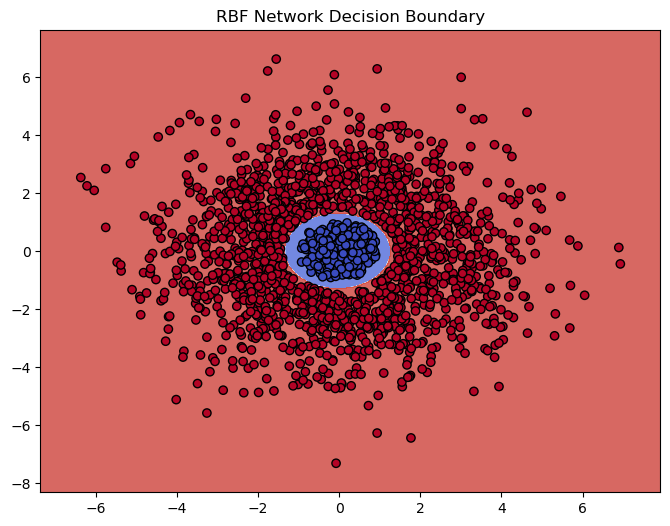

In [130]:
X, y = data1, label1
y = y.astype(np.float32)  # Convert to float for PyTorch compatibility

# Hyperparameters
input_dim = X.shape[1]  # Number of features
num_centers = 2  # Number of RBF centers
learning_rate = 0.01
epochs = 10000

centers, std_devs, labels = initialize_centers(X, num_centers)

# Convert data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Add dimension for binary classification

# Model, Loss function, Optimizer
model = RBFNetwork(input_dim, num_centers, 1, centers, std_devs)
criterion = nn.MSELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    # Forward pass
    model.train()
    outputs = model(X)
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
    
    Z = model(grid_tensor).detach().numpy().reshape(xx.shape)
    Z = (Z > 0.5).astype(int)  # Convert probabilities to class labels
    
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap='coolwarm', edgecolors='k')
    plt.title('RBF Network Decision Boundary')
    plt.show()

plot_decision_boundary(model, X.numpy(), y.numpy())

Epoch [1000/10000], Loss: 0.0089
Epoch [2000/10000], Loss: 0.0042
Epoch [3000/10000], Loss: 0.0027
Epoch [4000/10000], Loss: 0.0020
Epoch [5000/10000], Loss: 0.0016
Epoch [6000/10000], Loss: 0.0013
Epoch [7000/10000], Loss: 0.0011
Epoch [8000/10000], Loss: 0.0010
Epoch [9000/10000], Loss: 0.0009
Epoch [10000/10000], Loss: 0.0008


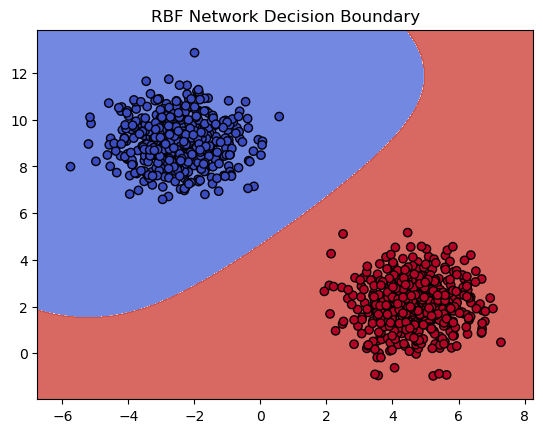

In [131]:
X, y = make_blobs(n_samples=1000, centers=2, cluster_std=1.0, random_state=42)
y = y.astype(np.float32)  # Convert to float for PyTorch compatibility

# Hyperparameters
input_dim = X.shape[1]  # Number of features
num_centers = 2  # Number of RBF centers
learning_rate = 0.1
epochs = 10000

centers, std_devs, labels = initialize_centers(X, num_centers)

# Convert data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Add dimension for binary classification

# Model, Loss function, Optimizer
model = RBFNetwork(input_dim, num_centers, 1, centers, std_devs)
criterion = nn.MSELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    # Forward pass
    model.train()
    outputs = model(X)
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
    
    Z = model(grid_tensor).detach().numpy().reshape(xx.shape)
    Z = (Z > 0.5).astype(int)  # Convert probabilities to class labels
    
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap='coolwarm', edgecolors='k')
    plt.title('RBF Network Decision Boundary')
    plt.show()

plot_decision_boundary(model, X.numpy(), y.numpy())


Epoch [1/20], Loss: 0.6185
Epoch [2/20], Loss: 0.2953
Epoch [3/20], Loss: 0.2266
Epoch [4/20], Loss: 0.2010
Epoch [5/20], Loss: 0.2057
Epoch [6/20], Loss: 0.1717
Epoch [7/20], Loss: 0.1209
Epoch [8/20], Loss: 0.0595
Epoch [9/20], Loss: 0.0981
Epoch [10/20], Loss: 0.0552
Epoch [11/20], Loss: 0.0974
Epoch [12/20], Loss: 0.0065
Epoch [13/20], Loss: 0.0698
Epoch [14/20], Loss: 0.0331
Epoch [15/20], Loss: 0.0213
Epoch [16/20], Loss: 0.0176
Epoch [17/20], Loss: 0.0507
Epoch [18/20], Loss: 0.0094
Epoch [19/20], Loss: 0.0089
Epoch [20/20], Loss: 0.0259


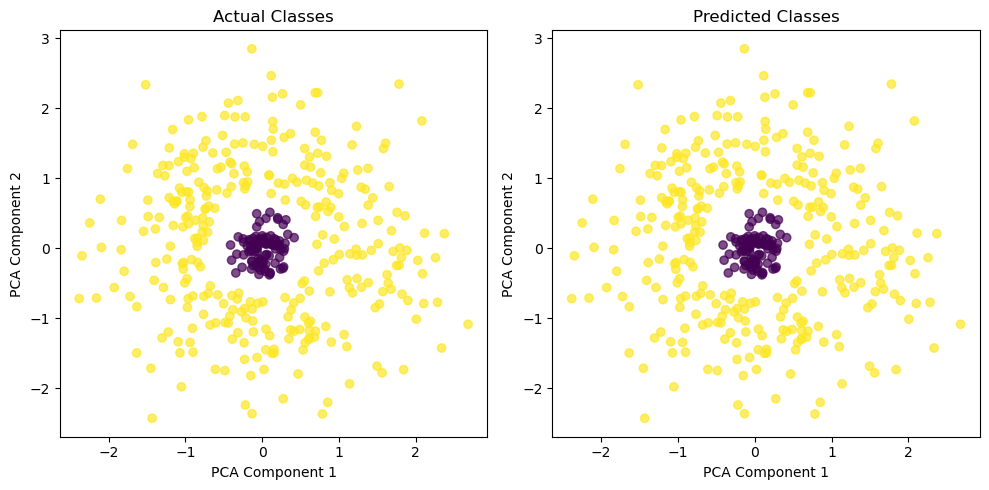

In [132]:
X = data1  # 1000 samples, 10 features
y = label1  # Binary classification (0 or 1)

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a simple 2-layer neural network
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = X_train.shape[1]  # After PCA, input size is 2
hidden_size = 64
output_size = 2  # Binary classification (2 classes)
learning_rate = 0.001
num_epochs = 20

# Initialize model, loss function, and optimizer
model = TwoLayerNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation and Visualization
model.eval()
with torch.no_grad():
    # Predict the labels for the test set
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Convert tensors back to numpy for plotting
X_test_np = X_test_tensor.numpy()
y_test_np = y_test_tensor.numpy()
predicted_np = predicted.numpy()

# Plotting the actual vs predicted points
plt.figure(figsize=(10, 5))

# Actual points
plt.subplot(1, 2, 1)
plt.scatter(X_test_np[:, 0], X_test_np[:, 1], c=y_test_np, cmap='viridis', alpha=0.7)
plt.title("Actual Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Predicted points
plt.subplot(1, 2, 2)
plt.scatter(X_test_np[:, 0], X_test_np[:, 1], c=predicted_np, cmap='viridis', alpha=0.7)
plt.title("Predicted Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()


<div dir="rtl">
همانطور که مشخص است یک شبکه عصبی ۲ لایه نیز میتواند دقت ۱۰۰ در ۱۰۰ داشته باش. اما در آزمایش ۲ دیدیم که نمیتوان با یک لایه اینکار را انجام داد.
در رابطه با هایپر پارامترها هم میتوان گفت که با کم کردن نرخ یادگیری دیرتر همگرا خواهیم شد اما نرخ یادگیری زیاد باعث واگرا شدن می شود.
</div>